# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

print('...')

...


## Visualize images 

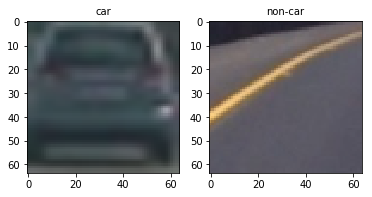

In [2]:
car_images = glob.glob("./training_dataset/vehicles/**/*.png")

car = cv2.imread(car_images[10])
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)


noncar_images = glob.glob("./training_dataset/non-vehicles/**/*.png")
noncar = cv2.imread(noncar_images[10])
noncar = cv2.cvtColor(noncar, cv2.COLOR_BGR2RGB)


fig, axs = plt.subplots(1,2)
axs[0].imshow(car)
axs[0].set_title('car', fontsize=10)
axs[1].imshow(noncar)
axs[1].set_title('non-car', fontsize=10)

fig.savefig('./examples/car_non_car.png', bbox_inches='tight')



In [3]:
print('no of car examples: ',len(car_images))

print('no of noncar examples: ',len(noncar_images))


no of car examples:  8792
no of noncar examples:  8968


#  Histogram of Oriented Gradients (HOG) features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

...


## Explore color spaces

In [5]:
#convert to HSV
car_rgb = cv2.cvtColor(car,cv2.COLOR_BGR2RGB)
car_hsv = cv2.cvtColor(car_rgb,cv2.COLOR_RGB2HSV)

noncar_rgb = cv2.cvtColor(noncar,cv2.COLOR_BGR2RGB)
noncar_hsv = cv2.cvtColor(noncar_rgb,cv2.COLOR_RGB2HSV)

#extract S channel info 
car_s_ch = car_hsv[:,:,1]
noncar_s_ch = noncar_hsv[:,:,1]


## Explore HOG params

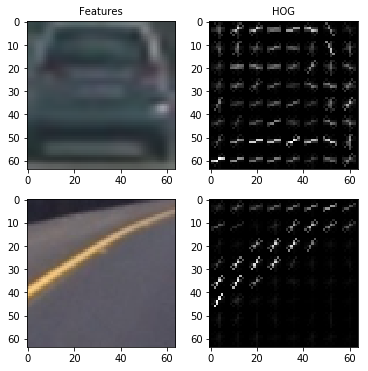

In [6]:
orient = 9
pix_per_cell = 8
cell_per_block = 8

features, car_hog = get_hog_features(car_s_ch, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


features, noncar_hog = get_hog_features(noncar_s_ch, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)



fig, axs = plt.subplots(2,2,figsize = (6,6))
axs[0,0].imshow(car)
axs[0,1].imshow(car_hog, cmap = 'gray')
axs[1,0].imshow(noncar)
axs[1,1].imshow(noncar_hog, cmap = 'gray')
axs[0,0].set_title('Features', fontsize = 10)
axs[0,1].set_title('HOG',fontsize = 10)

fig.savefig('./examples/HOG_example.png', bbox_inches='tight')


In [7]:
print(car.shape)
print(features.shape)
print(type(features))



(64, 64, 3)
(576,)
<class 'numpy.ndarray'>


In [8]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                      hist_bins=32, orient=9,
#                      pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                      spatial_feat=True, hist_feat=True, hog_feat=True):

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hog_feat=True):
    
    '''(imgs)-->features 
    
    Return a list of 1-d np.array and the len(list) = no.examples
    
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
 

            # Append the new feature vector to the features list
            features.append(hog_features)
        
            #file_features.append(hog_features)
        #features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

print('...')

...


# Extract HOG features from all example images 

In [9]:
#create X and y from car and noncar images
color_space = 'HSV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel='ALL'

t = time.time()
car_features = extract_features(car_images, cspace = color_space, orient = orient,
                     pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                     hog_channel = hog_channel)


noncar_features = extract_features(noncar_images,  cspace = color_space, orient = orient,
                     pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                     hog_channel = hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

61.57 Seconds to extract HOG features...


In [27]:
X = np.vstack((car_features,noncar_features)).astype(np.float64)

y = np.hstack((np.ones(len(car_features)),np.zeros(len(noncar_features))))

In [28]:
print(car_features[0].shape)

print(len(car_features))
print(type(car_features[0]))

car_labels = np.ones(car_features[0].shape)


(1188,)
8792
<class 'numpy.ndarray'>


In [29]:
## Per column (feature) Normalization

In [30]:
# # Fit a per-column scaler
# # find mean and std dev to be used for scaling on each feature
# scaler = StandardScaler()
# X_scaler = scaler.fit(X)

# # Apply the scaler to X
# # perform standardization by centering and scaling
# X = X_scaler.transform(X)

# ## X = scaler.fit_transform(X)

## 20-80 Split for train/validate

In [31]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


# Train Linear SVM and Validate

In [32]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
0.00154 Seconds to predict 10 labels with SVC



# Implement a sliding-window technique and use your trained classifier to search for vehicles in images

In [33]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('...')

...


### Test `Find_Cars` on an Example Image

In [38]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

5 rectangles found in image


In [39]:
## Method to Draw Rectangles onto an Image


In [40]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

...


...


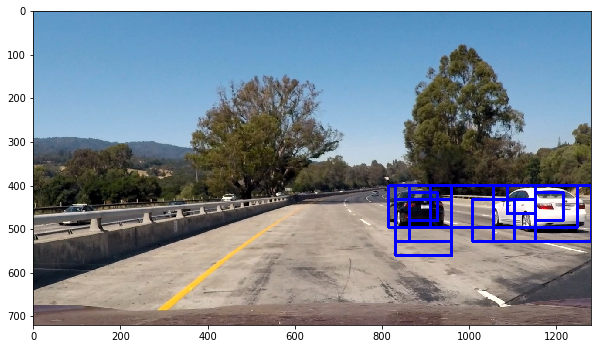

In [75]:
test_img_rects = draw_boxes(test_img, rectangles)
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(test_img_rects)


fig.savefig('./examples/sliding_window.png', bbox_inches='tight')

print('...')

### Combine Various Sliding Window Searches

In [49]:
def draw_rect(img):

    rectangles = []

    colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    # ystart = 400
    # ystop = 656
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 496
    # ystart = 400
    # ystop = 656
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 528
    # ystart = 400
    # ystop = 656
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))


    ystart = 400
    ystop = 596
    # ystart = 400
    # ystop = 656
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist]
    
    return rectangles
    


...


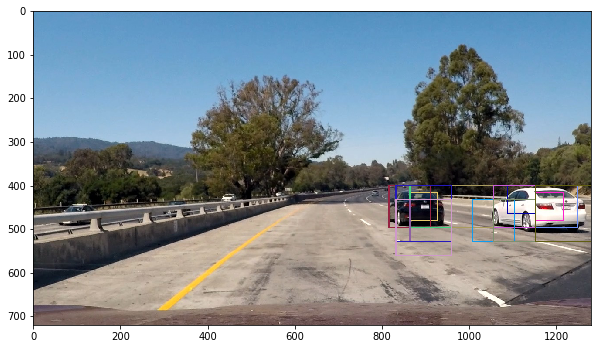

In [50]:
test_img = mpimg.imread('./test_images/test1.jpg')
rectangles  = draw_rect(test_img)
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


print('...')

### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [51]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('...')

...


6


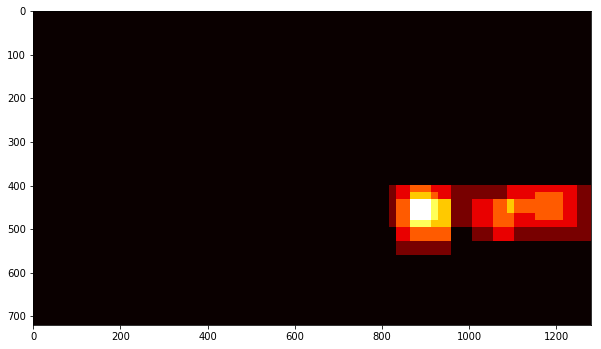

In [52]:
# Test out the heatmap
# Read in image similar to one shown above 
heatmap_img = np.zeros_like(test_img[:,:,0])

heatmap_img = add_heat(heatmap_img, rectangles)

plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print(np.max(heatmap_img))

### Apply a Threshold to the Heatmap

In [53]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('...')

...


...


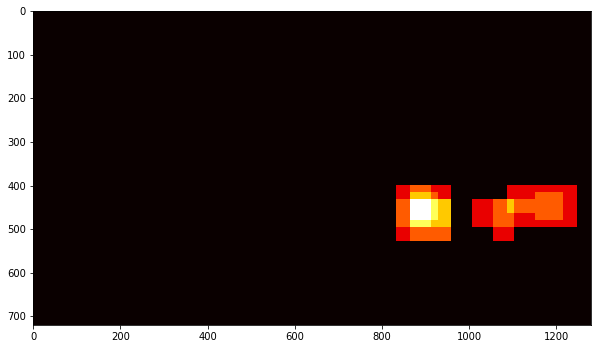

In [76]:
heatmap_img = apply_threshold(heatmap_img, 1)
# plt.figure(figsize=(10,10))
# plt.imshow(heatmap_img, cmap='hot')


fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(heatmap_img, cmap='hot')


fig.savefig('./examples/bboxes_and_heat.png', bbox_inches='tight')

print('...')

### Apply SciPy Labels to Heatmap

2 cars found


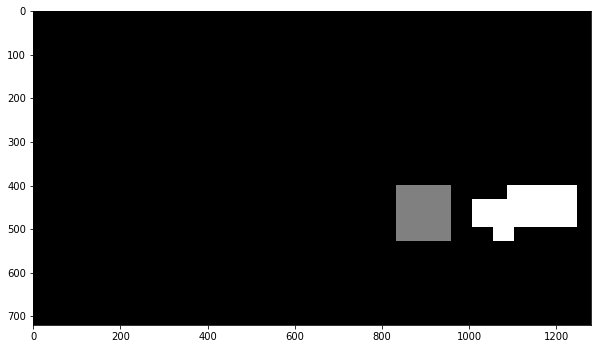

In [77]:
labels = label(heatmap_img)
# plt.figure(figsize=(10,10))
# plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(labels[0], cmap='gray')

fig.savefig('./examples/labels_map.png', bbox_inches='tight')



### Draw Bounding Boxes for Lables

In [62]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image and final rectangles
    return img



...


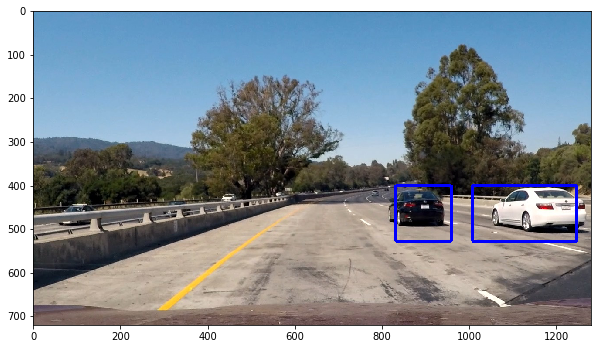

In [63]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

fig.savefig('./examples/output_bboxes.png', bbox_inches='tight')


print('...')

# Run a video through a pipeline

In [64]:
def process_image(img): 
    
    # construct bounding boxes
    rectangles = draw_rect(img)
    
    print (rectangles)  
    
    # Read in image similar to one shown above 
    heatmap_img = np.zeros_like(img[:,:,0])

    # Add heat to each box in box list
    heatmap_img = add_heat(heatmap_img, rectangles)

    # Apply threshold to help remove false positives
    heatmap_img = apply_threshold(heatmap_img, 1)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

i am at image : 0
[((1088, 400), (1152, 464)), ((864, 416), (928, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1056, 400), (1152, 496)), ((1152, 400), (1248, 496)), ((864, 432), (960, 528)), ((1008, 432), (1104, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528)), ((1152, 400), (1280, 528)), ((832, 432), (960, 560))]
i am at image : 1
[]
i am at image : 2
[((896, 400), (960, 464)), ((896, 416), (960, 480)), ((864, 400), (960, 496))]
i am at image : 3
[((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 432), (1200, 528)), ((832, 400), (960, 528))]
i am at image : 4
[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((96, 432), (192, 528)), ((1104, 432), (1200, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1088, 432), (1216, 560))]
i am at image : 5
[((0, 400), (64, 464)), ((816, 400), (912, 496)), ((832, 400), (960, 528)), ((832, 432), (960, 560))]
...


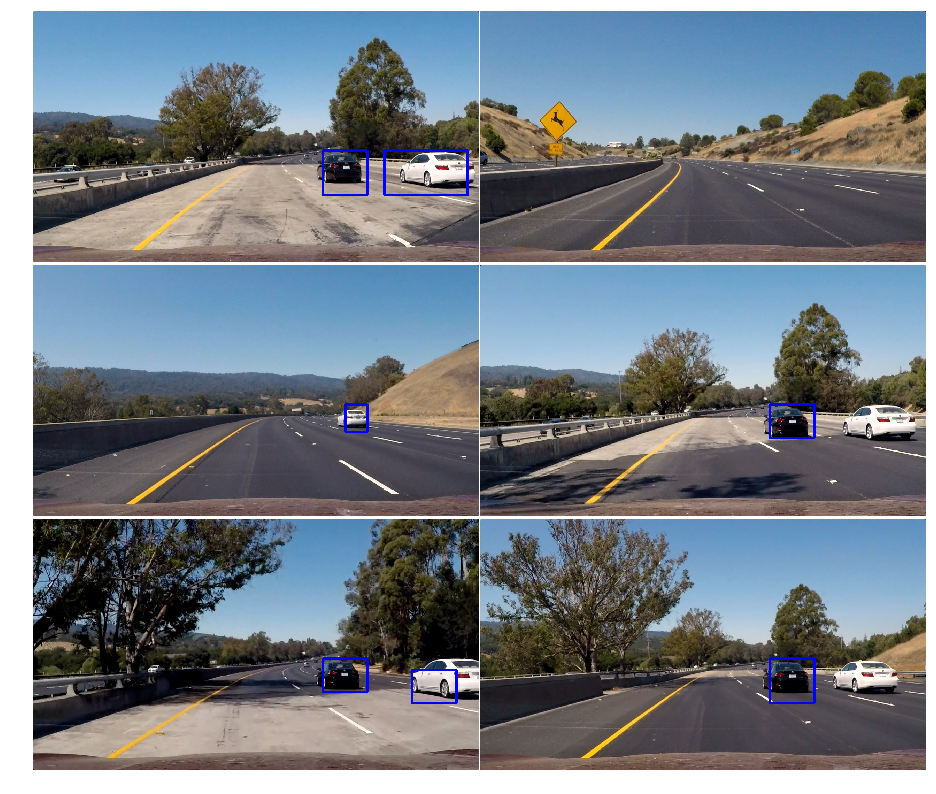

In [65]:

# test_img = mpimg.imread('./test_images/test3.jpg')

# draw_img = process_image(test_img)
# plt.figure(figsize=(10,10))
# plt.imshow(draw_img)
# print('...')



test_images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, img in enumerate(test_images):
    
    print ("i am at image :", i)
    
    draw_img = process_image(mpimg.imread(img))
    axs[i].imshow(draw_img)
    axs[i].axis('off')

    
fig.savefig('./examples/sliding_windows.png', bbox_inches='tight')

print('...')

In [66]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[((1104, 400), (1200, 496)), ((832, 400), (960, 528))]
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


  3%|▎         | 1/39 [00:00<00:11,  3.40it/s]

[((1104, 400), (1200, 496)), ((832, 400), (960, 528))]


  5%|▌         | 2/39 [00:00<00:10,  3.40it/s]

[((1056, 400), (1152, 496)), ((832, 400), (960, 528))]


  8%|▊         | 3/39 [00:00<00:10,  3.43it/s]

[((1024, 400), (1088, 464)), ((832, 400), (960, 528))]


 10%|█         | 4/39 [00:01<00:10,  3.44it/s]

[((1120, 400), (1184, 464)), ((1104, 400), (1200, 496)), ((1104, 432), (1200, 528)), ((832, 400), (960, 528))]


 13%|█▎        | 5/39 [00:01<00:09,  3.45it/s]

[((1088, 416), (1152, 480)), ((336, 400), (432, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528))]


 15%|█▌        | 6/39 [00:01<00:09,  3.46it/s]

[((1104, 400), (1200, 496)), ((832, 400), (960, 528))]


 18%|█▊        | 7/39 [00:02<00:09,  3.44it/s]

[((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((288, 400), (384, 496)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528))]


 21%|██        | 8/39 [00:02<00:09,  3.41it/s]

[((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528))]


 23%|██▎       | 9/39 [00:02<00:08,  3.36it/s]

[((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((240, 400), (336, 496)), ((240, 432), (336, 528)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528))]


 26%|██▌       | 10/39 [00:02<00:08,  3.32it/s]

[((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((240, 400), (336, 496)), ((1008, 400), (1104, 496)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 28%|██▊       | 11/39 [00:03<00:08,  3.29it/s]

[((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((336, 400), (432, 496)), ((1008, 432), (1104, 528)), ((128, 400), (256, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 31%|███       | 12/39 [00:03<00:08,  3.28it/s]

[((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((144, 400), (240, 496)), ((240, 400), (336, 496)), ((144, 432), (240, 528)), ((1008, 432), (1104, 528)), ((128, 400), (256, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 33%|███▎      | 13/39 [00:03<00:07,  3.31it/s]

[((1088, 400), (1152, 464)), ((1104, 400), (1200, 496)), ((96, 432), (192, 528)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 36%|███▌      | 14/39 [00:04<00:07,  3.31it/s]

[((1088, 400), (1152, 464)), ((224, 416), (288, 480)), ((192, 400), (288, 496)), ((288, 400), (384, 496)), ((864, 400), (960, 496)), ((1008, 432), (1104, 528)), ((0, 400), (128, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((0, 432), (128, 560))]


 38%|███▊      | 15/39 [00:04<00:07,  3.30it/s]

[((1088, 400), (1152, 464)), ((480, 400), (576, 496)), ((1008, 432), (1104, 528)), ((128, 400), (256, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 41%|████      | 16/39 [00:04<00:07,  3.27it/s]

[((1216, 400), (1280, 464)), ((128, 416), (192, 480)), ((1008, 400), (1104, 496)), ((0, 432), (96, 528)), ((96, 432), (192, 528)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 44%|████▎     | 17/39 [00:05<00:06,  3.25it/s]

[((96, 400), (192, 496)), ((864, 400), (960, 496)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 46%|████▌     | 18/39 [00:05<00:06,  3.27it/s]

[((1056, 400), (1120, 464)), ((1152, 400), (1216, 464)), ((48, 432), (144, 528)), ((96, 432), (192, 528)), ((1008, 432), (1104, 528)), ((256, 400), (384, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 49%|████▊     | 19/39 [00:05<00:06,  3.28it/s]

[((1056, 400), (1120, 464)), ((48, 400), (144, 496)), ((48, 432), (144, 528)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 51%|█████▏    | 20/39 [00:05<00:05,  3.32it/s]

[((1056, 400), (1120, 464)), ((1008, 432), (1104, 528)), ((1152, 432), (1248, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 54%|█████▍    | 21/39 [00:06<00:05,  3.34it/s]

[((1056, 400), (1120, 464)), ((1152, 400), (1216, 464)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((48, 432), (144, 528)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 56%|█████▋    | 22/39 [00:06<00:05,  3.33it/s]

[((1056, 400), (1120, 464)), ((1104, 400), (1200, 496)), ((1008, 432), (1104, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 59%|█████▉    | 23/39 [00:06<00:04,  3.35it/s]

[((1056, 400), (1120, 464)), ((1120, 416), (1184, 480)), ((1104, 400), (1200, 496)), ((672, 432), (768, 528)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 62%|██████▏   | 24/39 [00:07<00:04,  3.36it/s]

[((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 64%|██████▍   | 25/39 [00:07<00:04,  3.34it/s]

[((1120, 400), (1184, 464)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 67%|██████▋   | 26/39 [00:07<00:03,  3.33it/s]

[((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((864, 400), (960, 496)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 69%|██████▉   | 27/39 [00:08<00:03,  3.28it/s]

[((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((864, 400), (960, 496)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((832, 432), (960, 560))]


 72%|███████▏  | 28/39 [00:08<00:03,  3.29it/s]

[((1120, 400), (1184, 464)), ((864, 400), (960, 496)), ((624, 432), (720, 528)), ((832, 400), (960, 528))]


 74%|███████▍  | 29/39 [00:08<00:02,  3.34it/s]

[((1120, 400), (1184, 464)), ((864, 400), (960, 496)), ((832, 400), (960, 528))]


 77%|███████▋  | 30/39 [00:08<00:02,  3.33it/s]

[((1120, 400), (1184, 464)), ((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((832, 400), (960, 528))]


 79%|███████▉  | 31/39 [00:09<00:02,  3.39it/s]

[((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((864, 400), (960, 496)), ((832, 400), (960, 528))]


 82%|████████▏ | 32/39 [00:09<00:02,  3.41it/s]

[((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((832, 400), (960, 528))]


 85%|████████▍ | 33/39 [00:09<00:01,  3.44it/s]

[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((832, 400), (960, 528))]


 87%|████████▋ | 34/39 [00:10<00:01,  3.46it/s]

[((864, 400), (960, 496)), ((832, 400), (960, 528)), ((1152, 400), (1280, 528))]


 90%|████████▉ | 35/39 [00:10<00:01,  3.44it/s]

[((192, 400), (288, 496)), ((864, 400), (960, 496)), ((864, 432), (960, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528))]


 92%|█████████▏| 36/39 [00:10<00:00,  3.46it/s]

[((864, 400), (960, 496)), ((864, 432), (960, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528))]


 95%|█████████▍| 37/39 [00:11<00:00,  3.46it/s]

[((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((864, 432), (960, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528))]


 97%|█████████▋| 38/39 [00:11<00:00,  3.44it/s]

[((320, 416), (384, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((864, 432), (960, 528)), ((1056, 432), (1152, 528)), ((832, 400), (960, 528))]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 10.7 s, sys: 2.54 s, total: 13.2 s
Wall time: 12 s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [68]:
def process_frame_for_video(img):
    
    rectangles = draw_rect(img)
   
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


In [69]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

...


In [70]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [06:17<00:00,  3.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min 55s, sys: 1min 20s, total: 7min 15s
Wall time: 6min 17s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))